# Do job resource allocation requests cluster together?


The following exploratory analysis attempts to classify job types within the general partition on Longleaf (June 2018).  The basic assumption here is high memory and CPU density within single nodes results in resource contention.  

E.G.:
* High memory, low CPU jobs prevent jobs from running as the memory required for future jobs is allocated in spite of free CPUs

Data presented here is based on user job allocation requests.  Actual usage data will follow.

## Basic Setup

1. Import necessary python packages and custom code.
2. Read in Fiscal Year 2018 jobs
 * Randomize and subset data
3. Clean dataset and add new features
 * mem_req_mod (GB)- convert SLURM's memory convention to total memory requested for job
 * cpus_per_node - clean few jobs requesting cores across nodes (spark)
 * timelimit_hrs - convert requested time to hours
 * Including jobs of any state as long as 4 runtime was at least seconds 
 * Focus only on general partition
 

In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy
import pandas
import sklearn.cluster
import sklearn.preprocessing
import utils

%matplotlib inline

In [2]:
# set plot defaults
plt.rcParams['figure.figsize'] = [16, 5]
plt.style.use('bmh')

# read sampled data file
data_file = "longleaf_job_data_fy2018_res.csv"
n = 1000  # every N line, or random select of 1 / nth the size
df = utils.read_sampled_file(data_file, N=n, random_sampling=True)

In [3]:
# Clean data & add new features
df['mem_req_mod'] = df['mem_req'].apply(lambda x: x - 9223372036854775808 if x > 9223372036854775808 else (x - 2147483648 if x > 2147483648 else x))
df['mem_req_mod'] = df['mem_req_mod'] / 1024

df['cpus_per_node'] = df['cpus_req'] / df['nodes_alloc']
df = df[df['cpus_per_node'] <= 56]

df['timelimit_hrs'] = df['timelimit'] / 60

df = df[df['mem_req_mod'] <= 3000]
df = df[df['time_start'] > 0]
df = df[(df['time_end'] - df['time_start']) > 4]

In [4]:
# focus on general partition
general_df = df.where(df['partition'] == 'general').dropna()

# remove unnecessary features
features = ['cpus_per_node', 'mem_req_mod', 'timelimit_hrs']
general_df = general_df[features]
del(df)

## Do job requests cluster by resources request?  CPUs vs MEM

Jitter added for visualization purposes.

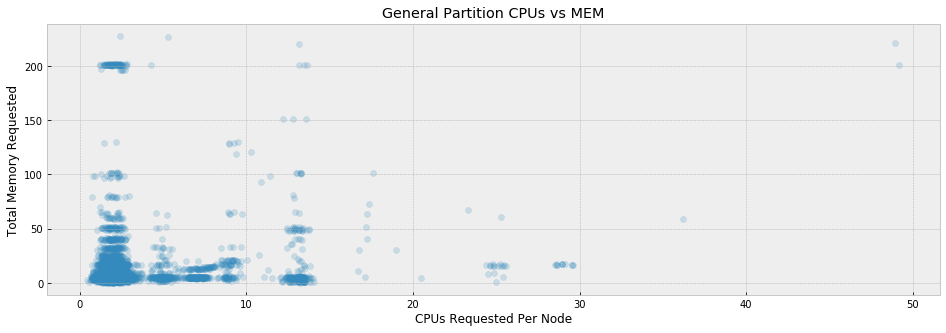

In [5]:
plt.scatter(utils.add_jitter(general_df['cpus_per_node']), utils.add_jitter(general_df['mem_req_mod']), alpha=.2)
plt.xlabel('CPUs Requested Per Node')
plt.ylabel('Total Memory Requested')
plt.title('General Partition CPUs vs MEM');

## Normalize Data

Data is scaled for quantification and visualization purposes.

In [6]:
scaled_values = sklearn.preprocessing.StandardScaler().fit_transform(general_df.loc[:, features].values)
scaled_df = pandas.DataFrame(data=scaled_values, columns=features)

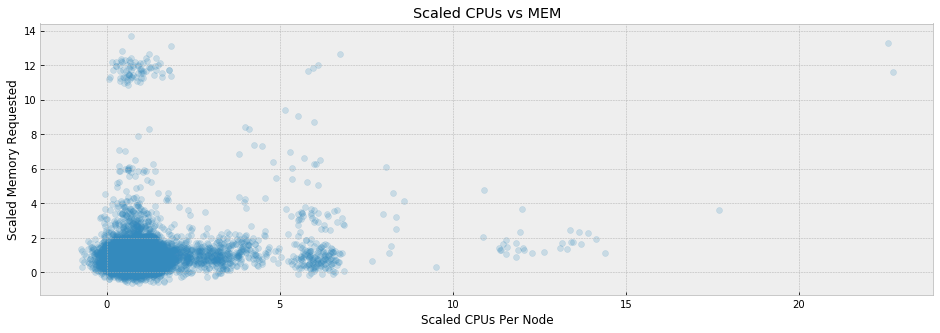

In [7]:
plt.scatter(utils.add_jitter(scaled_df['cpus_per_node']), utils.add_jitter(scaled_df['mem_req_mod']), alpha=.2)
plt.xlabel('Scaled CPUs Per Node')
plt.ylabel('Scaled Memory Requested')
plt.title('Scaled CPUs vs MEM');

## Cluster Analysis

See which job submissions are most similar to each other.  Can we quantify this using K means cluster? Can this provide insight on new parition schemes?  

### Elbow Method

Attempt to determine an appropriate number of clusters by minimizing sum of squared distance of each point to local cluster's centroid.  Want to select the smalled number of clusters that results in sufficient clustering.  Increasing K will yield better clustering performance, but will be computationally intensive and result in too many partitions in practice.

Generally, the "best" option is in the "bend of the elbow".  

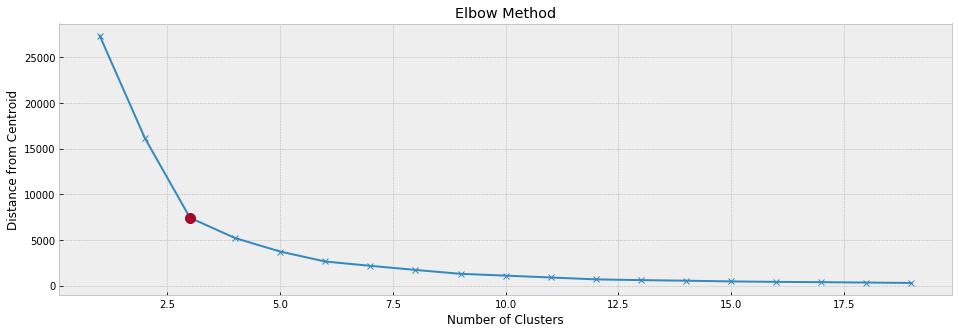

In [8]:
Nc = 20
scaled_X = numpy.array(list(zip(scaled_df['cpus_per_node'], scaled_df['mem_req_mod'])))
elbow_data = utils.elbow_method(scaled_X, num_clusters=Nc)

plt.plot(range(1, Nc), elbow_data, 'x-')
plt.plot(3, elbow_data[2], 'o', markersize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('Distance from Centroid')
plt.title('Elbow Method');

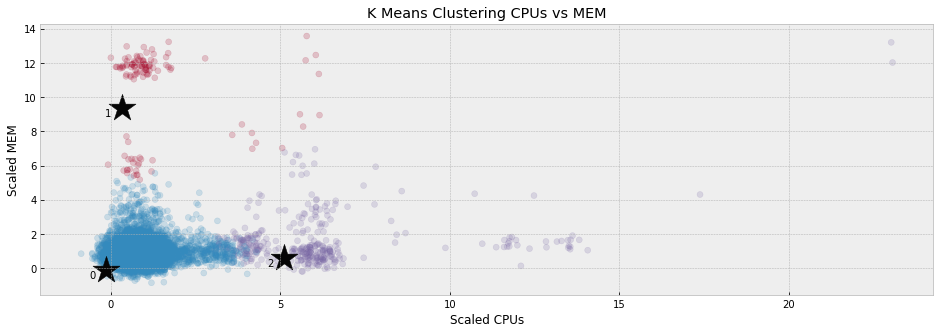

In [9]:
number_of_clusters = 3
labels, centroids = utils.kmeans_cluster(scaled_X, number_of_clusters)

colormap = dict([(i,e) for i,e in enumerate(plt.rcParams['axes.prop_cycle'].by_key()['color'])])
colors = [colormap.get(l) for l in labels]

plt.scatter(utils.add_jitter(scaled_df['cpus_per_node']), utils.add_jitter(scaled_df['mem_req_mod']), alpha=.2, c=colors)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#050505', s=800)
plt.xlabel('Scaled CPUs')
plt.ylabel('Scaled MEM')
plt.title('K Means Clustering CPUs vs MEM');

for i,c in enumerate(centroids):
    plt.annotate(i, (centroids[i,0]-0.5, centroids[i,1]-0.5))

In [10]:
general_df['labels'] = labels
categories = general_df.groupby('labels')
categories[['cpus_per_node', 'mem_req_mod']].describe()

cpus_per_node                                                   \
               count       mean       std  min  25%   50%   75%   max   
labels                                                                  
0            13204.0   1.130030  0.708594  1.0  1.0   1.0   1.0   6.0   
1              116.0   2.094828  3.024475  1.0  1.0   1.0   1.0  12.0   
2              354.0  12.163842  5.504183  7.0  8.0  12.0  12.0  48.0   

       mem_req_mod                                                     \
             count        mean        std        min    25%       50%   
labels                                                                  
0          13204.0    5.291367   6.779488   0.004883    2.0    4.0000   
1            116.0  174.698478  42.364831  96.000000  128.0  200.0000   
2            354.0   17.521220  25.915517   0.019531    4.0    4.6875   

                         
             75%    max  
labels                   
0         4.6875   80.0  
1       200.0000  227.0  
2        20.0000  220.0

In [11]:
job_count = categories.describe()['cpus_per_node']['count']
for i,c in job_count.items():
    print("Category %d: %10.2f percent of jobs" % (i, c/sum(job_count)*100))

Category 0:      96.56 percent of jobs
Category 1:       0.85 percent of jobs
Category 2:       2.59 percent of jobs


## Apply labels to original data

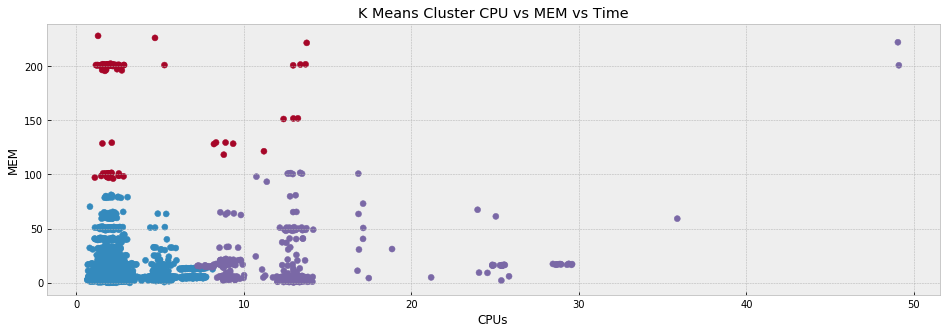

In [17]:
plt.scatter(utils.add_jitter(general_df['cpus_per_node']), utils.add_jitter(general_df['mem_req_mod']), c=colors)
plt.xlabel('CPUs')
plt.ylabel('MEM')
plt.title('K Means Cluster CPU vs MEM vs Time');

## What happens when we add time allocation requests?

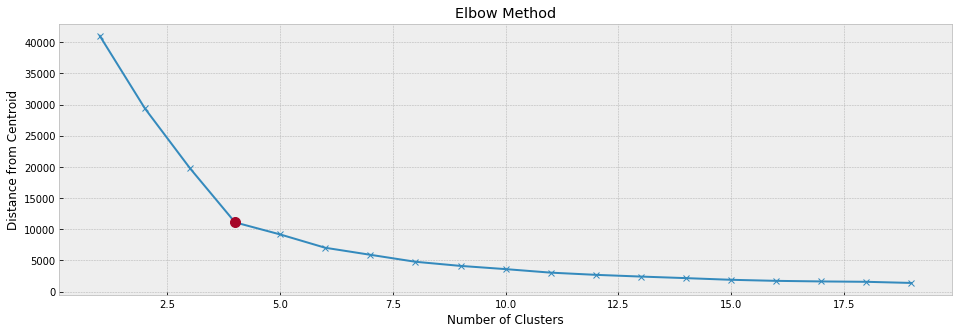

In [13]:
Nc = 20
scaled_X = numpy.array(list(zip(scaled_df['cpus_per_node'], scaled_df['mem_req_mod'], scaled_df['timelimit_hrs'])))
elbow_data = utils.elbow_method(scaled_X, num_clusters=Nc)

plt.plot(range(1, Nc), elbow_data, 'x-')
plt.plot(4, elbow_data[3], 'o', markersize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('Distance from Centroid')
plt.title('Elbow Method');

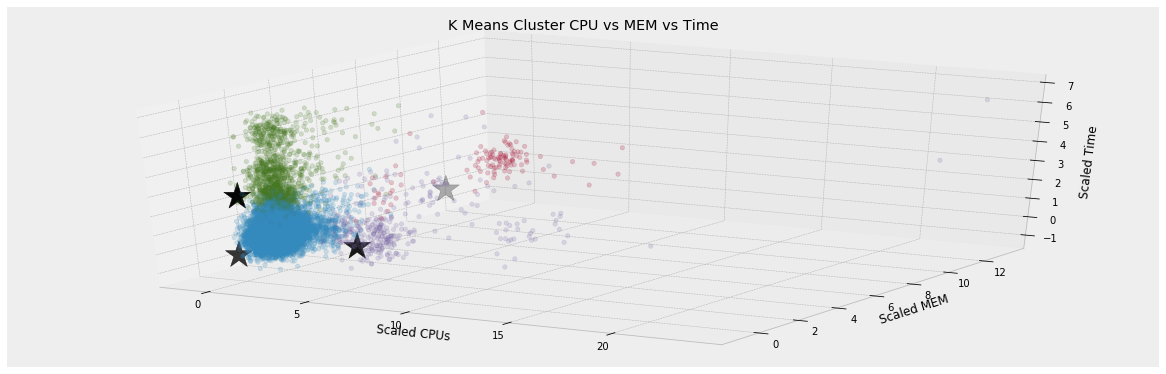

In [19]:
number_of_clusters = 4
labels, centroids = utils.kmeans_cluster(scaled_X, number_of_clusters)
colors = [colormap.get(l) for l in labels]

ax = mpl_toolkits.mplot3d.Axes3D(plt.figure())
ax.scatter(utils.add_jitter(scaled_df['cpus_per_node']), utils.add_jitter(scaled_df['mem_req_mod']), utils.add_jitter(scaled_df['timelimit_hrs']), alpha=.2, c=colors)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:,2], marker='*', c='#050505', s=800)
ax.set_xlabel('Scaled CPUs')
ax.set_ylabel('Scaled MEM')
ax.set_zlabel('Scaled Time')
ax.set_title('K Means Cluster CPU vs MEM vs Time');

In [15]:
general_df['labels'] = labels
categories = general_df.groupby('labels')
categories[['cpus_per_node', 'mem_req_mod', 'timelimit_hrs']].describe()

cpus_per_node                                                   \
               count       mean       std  min  25%   50%   75%   max   
labels                                                                  
0            11996.0   1.138872  0.735352  1.0  1.0   1.0   1.0   6.0   
1             1215.0   1.070782  0.554978  1.0  1.0   1.0   1.0   8.0   
2              114.0   2.114035  3.047584  1.0  1.0   1.0   1.0  12.0   
3              349.0  12.223496  5.520746  7.0  8.0  12.0  12.0  48.0   

       mem_req_mod              ...                    timelimit_hrs  \
             count        mean  ...         75%    max         count   
labels                          ...                                    
0          11996.0    4.927266  ...      4.6875   80.0       11996.0   
1           1215.0    9.137220  ...     10.0000  100.0        1215.0   
2            114.0  176.008978  ...    200.0000  227.0         114.0   
3            349.0   17.365363  ...     16.0000  220.0         349.0   

                                                                      
              mean        std        min    25%    50%    75%    max  
labels                                                                
0        12.799435  16.409114   0.016667    1.0    3.0   24.0   84.0  
1       158.951578  59.901706  80.000000  100.0  156.0  168.0  264.0  
2        49.848684  31.709119   0.916667   48.0   48.0   48.0  240.0  
3        50.290353  54.779276   0.016667    4.0   48.0   72.0  264.0  

[4 rows x 24 columns]

In [16]:
job_count = categories.describe()['cpus_per_node']['count']
for i,c in job_count.items():
    print("Category %d: %10.2f percent of jobs" % (i, c/sum(job_count)*100))

Category 0:      87.73 percent of jobs
Category 1:       8.89 percent of jobs
Category 2:       0.83 percent of jobs
Category 3:       2.55 percent of jobs


## Apply labels to original data

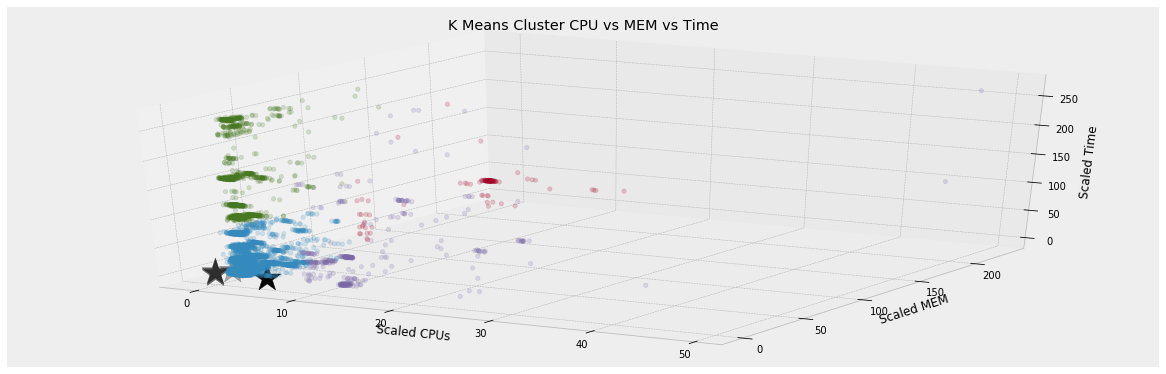

In [21]:
ax = mpl_toolkits.mplot3d.Axes3D(plt.figure())
ax.scatter(utils.add_jitter(general_df['cpus_per_node']), utils.add_jitter(general_df['mem_req_mod']), utils.add_jitter(general_df['timelimit_hrs']), alpha=.2, c=colors)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:,2], marker='*', c='#050505', s=800)
ax.set_xlabel('Scaled CPUs')
ax.set_ylabel('Scaled MEM')
ax.set_zlabel('Scaled Time')
ax.set_title('K Means Cluster CPU vs MEM vs Time');